Given a set of angles and a fixed distance from origin (DSO), we visualize  the corresponding camera poses in 2D and 3D space. Rays are assumed to be parallel to each other (parallel mode).

In [1]:
import numpy as np
import torch

def angle2pose(DSO, angle):
    """Starting from an angle in radiants, it returns the 4x4 transformation matrix.
    It is composed by rotation matrix R and translation vector t.
    Translation matrix is espressed in homogeneous coordinates
    
    Args:
        DSO: distance source-origin
        angle: angle in degree
    """

    # rotation around X-axis
    phi1 = -np.pi / 2
    R1 = np.array([[1.0, 0.0, 0.0],
                [0.0, np.cos(phi1), -np.sin(phi1)],
                [0.0, np.sin(phi1), np.cos(phi1)]])

    # rotation around Z-axis
    phi2 = np.pi / 2
    R2 = np.array([[np.cos(phi2), -np.sin(phi2), 0.0],
                [np.sin(phi2), np.cos(phi2), 0.0],
                [0.0, 0.0, 1.0]])
    
    # rotation around Z-axis by the input angle
    R3 = np.array([[np.cos(angle), -np.sin(angle), 0.0],
                [np.sin(angle), np.cos(angle), 0.0],
                [0.0, 0.0, 1.0]])
    
    # full rotation to transform the 3D coordinate system
    # based on the given input angle
    rot = np.dot(np.dot(R3, R2), R1)

    # translation vector to get camera/source position
    # forms a radius DSO in the XY-plane, Z is zero
    trans = np.array([DSO * np.cos(angle), DSO * np.sin(angle), 0])
    
    # homogeneous transformation matrix T
    T = np.eye(4)
    T[:-1, :-1] = rot
    T[:-1, -1] = trans
    return T

def get_rays(angles, W, H, DSO, dDetector, offDetector, device):
    """From a list of angles and a fixed distance, it returns position and orientation
    of each camera/source.

    Args:
        angles: list of angles in radiants
        W: width of the camera
        H: height of the camera
        DSO: distance source origin
        dDetector: dimension of the detector
        offDetector: offset of the detector
        device: cpu or gpu
    """

    rays = []                       # list to store ray data for each angle
    
    for angle in angles:
        pose = torch.Tensor(angle2pose(DSO, angle)).to(device)
        rays_o, rays_d = None, None

        # get 2D coordinates (pixel locations) on the detector
        i, j = torch.meshgrid(torch.linspace(0, W - 1, W, device=device),
                                torch.linspace(0, H - 1, H, device=device), indexing="ij")
        
        # physical position of each pixel on detector
        uu = (i.t() + 0.5 - W / 2) * dDetector[0] + offDetector[0]
        vv = (j.t() + 0.5 - H / 2) * dDetector[1] + offDetector[1]
        
        # directions of rays in 3D space
        # all rays travel parallel to Z-axis
        # directions are [0, 0, 1], only movement along Z-axis
        dirs = torch.stack([torch.zeros_like(uu),
                            torch.zeros_like(uu),
                            torch.ones_like(uu)], -1)
        
        # computes direction vector after applying the rotation
        rays_d = torch.sum(torch.matmul(pose[:3,:3], dirs[..., None]).to(device), -1)
        
        # computes the origins of the rays
        rays_o = torch.sum(torch.matmul(pose[:3,:3], torch.stack([uu,vv,torch.zeros_like(uu)],-1)[..., None]).to(device), -1) + pose[:3, -1].expand(rays_d.shape)

        rays.append(torch.concat([rays_o, rays_d], dim=-1))

    return torch.stack(rays, dim=0)

c:\Users\marco\.conda\envs\sax_nerf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [71]:
import matplotlib.pyplot as plt

def visualize_rays_2d(rays_o, rays_d):
    num_rays = rays_o.shape[0]

    fig, ax = plt.subplots()
    rays_o = rays_o[:num_rays]
    rays_d = rays_d[:num_rays]

    # origins
    ax.scatter(rays_o[:, 0].cpu().numpy(), 
               rays_o[:, 1].cpu().numpy(), 
               color="blue", label="Ray Origins")
    
    # directions
    for i in range(num_rays):
        origin = rays_o[i].cpu().numpy()
        direction = rays_d[i].cpu().numpy()

        ax.arrow(origin[0], 
                 origin[1], 
                 direction[0] * 0.05, 
                 direction[1] * 0.05, 
                 head_width=0.01, head_length=0.01, fc='red', ec='red')
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("2D Ray Origins and Directions")
    ax.legend()

    plt.grid(True)
    plt.show()

torch.Size([36, 1, 1, 6])


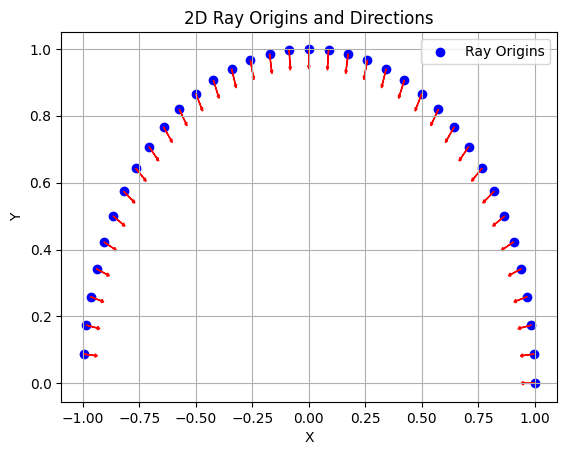

In [76]:
angles = np.radians(np.arange(0, 180, 5))

DSO = 1.0 # distance to origin.
W, H = (1, 1) # detector width and height
dDetector = [1.0, 1.0]
offDetector = [0, 0]
device = torch.device('cpu')

rays = get_rays(angles, W, H, DSO, dDetector, offDetector, device) # [n_angles, W, H, 6]

print(rays.shape)

rays_o = rays[:, 0, 0, :3]  # First three values are origins
rays_d = rays[:, 0, 0, 3:]  # Last three values are directions

visualize_rays_2d(rays_o, rays_d)
